# Fisher matrix calculation walkthrough

This notebook contains an example Fisher matrix calculation, which computes the Fisher matrix for the standard cosmological parameters. The notebook will use `CLASS`, which is a cosmological Boltzmann solver similar to `CAMB`. Both codes compute $C^{XX}_\ell$ (where $XX=\{TT, EE, TE\}$) for a given cosmology, which is a necessary ingredient for a Fisher matrix calculation. To begin, let's consider a Fisher matrix computed while ignoring instrumental noise. This is sometimes referred to as a "cosmic variance limited" (CVL) experiment, since the error comes only from cosmic variance. 

With or without noise, the Fisher matrix is given by:

\begin{equation}
F_{ij} = \sum_\ell \left(\frac{\partial C_\ell}{\partial \theta_i}\right)^\intercal \cdot \Sigma_\ell^{-1} \cdot \left(\frac{\partial C_\ell}{\partial \theta_j}\right)
\end{equation}

These terms merit some explanation. First, the $\theta_i$ refer to one of the parameters you are interested in forecasting. In this example, this will be one of the six standard cosmological parameters. There is some freedom in how you choose to parameterize the standard cosmological model, but to be concrete we will say that $\theta_i$ is one of $\{\omega_b, \omega_{cdm}, n_s, \tau_{reio}, \ln(10^{10} A_s), H_0 \}$. We see from the above expression for $F$ that our final Fisher matrix should then be $6 \times 6$, since we have six parameters. 

Next, $\Sigma_\ell$ is the *error covariance matrix*, and in the absence of instrumental noise is given by:

\begin{equation} \tag{2}
\Sigma_\ell = \frac{2}{f_{sky}\left(2\ell+1\right)} \begin{pmatrix}
\left(C^{TT}_\ell \right)^2 & \left(C^{TE}_\ell \right)^2 & C^{TT}_\ell C^{TE}_\ell\\
\left(C^{TE}_\ell \right)^2 & \left(C^{EE}_\ell \right)^2 & C^{EE}_\ell C^{TE}_\ell \\
C^{TT}_\ell C^{TE}_\ell & C^{EE}_\ell C^{TE}_\ell & 0.5\left( (C^{TE}_\ell)^2 + C^{TT}_\ell C^{EE}_\ell \right) \\
\end{pmatrix}\end{equation}

Here, $f_{sky}$ is a factor that accounts for the fact that CMB experiments do not cover the entire sky. For Planck-like experiments you can use $f_{sky} = 0.8$. Finally, you might notice that that $C_\ell$'s that appear in equation (1) don't have a TT, TE, or EE attached. In this equation, we should understand these to be vectors of all three in the order:

\begin{equation} \tag{3}
 \left(\frac{\partial C_\ell}{\partial \theta_i}\right)^\intercal = \left(\frac{\partial C^{TT}_\ell}{\partial \theta_i}, \frac{\partial C^{EE}_\ell}{\partial \theta_i}, \frac{\partial C^{TE}_\ell}{\partial \theta_i} \right)
\end{equation}

You can think of this as a $1 \times 3 \times \ell_{max}$ dimensional tensor if you'd like.

Before getting to the calculation, one final thing to note is that the Fisher matrix depends on the point in parameter space we are at. That is, we calculate the Fisher matrix for one particular model (choice of parameters) which I will refer to as the fiducial model. The $C^{XX}_\ell$ that appear in $\Sigma_\ell$ are the $C_\ell$'s calculated with the fiducial parameters, and the derivatives in Eq. (3) are evaluated at the fiducial parameters. So we could really write those derivatives as $\frac{\partial C^{TT}_\ell}{\partial \theta_i}|_{\vec{\theta} = \vec{\theta_{fid}}}$ to be precise.

Let's start the calculation by computing the fiducial power spectra.


In [13]:
import classy as Class
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
from IPython.display import display, clear_output

######################################################
#  Setting up plots
######################################################

%config InlineBackend.figure_format = 'retina'
font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.mathtext.rcParams['legend.fontsize']='medium'
plt.rcParams["figure.figsize"] = [8.0,6.0]

######################################################
#  Setting fiducial parameters
#  Planck18 TT,TE,EE+lowE+lensing+BAO
######################################################

ln10e10As = 3.047
As = np.exp(ln10e10As)/(10**10)

#I like to make a seperate dictionary of my parameters and just reference this throughout.
#That way if I change a parameter, it changes everywhere
standard_params = {
    "omega_b": 0.02242,
    "omega_cdm": 0.11933,
    "n_s": 0.9665,
    "tau_reio": 0.0561,
    "ln10^{10}A_s": ln10e10As,
    "H0": 67.66
}

common_settings = {'output' : 'tCl,pCl,lCl',
                   # LambdaCDM parameters
                   'H0':standard_params["H0"],
                   'omega_b':standard_params["omega_b"],
                   'omega_cdm':standard_params["omega_cdm"],
                   'ln10^{10}A_s': standard_params["ln10^{10}A_s"],
                   'n_s':standard_params["n_s"],
                   'tau_reio': standard_params["tau_reio"],
                   # Other CLASS parameters, you can ignore
                   'thermodynamics_verbose': 0,
                   'input_verbose': 0,
                   'lensing': 'yes',
                   'xe_pert_type': 'none'
                   }

M = Class.Class()
M.set(common_settings)

True

In [14]:
#This function call runs CLASS and computes C_l's 
M.compute()

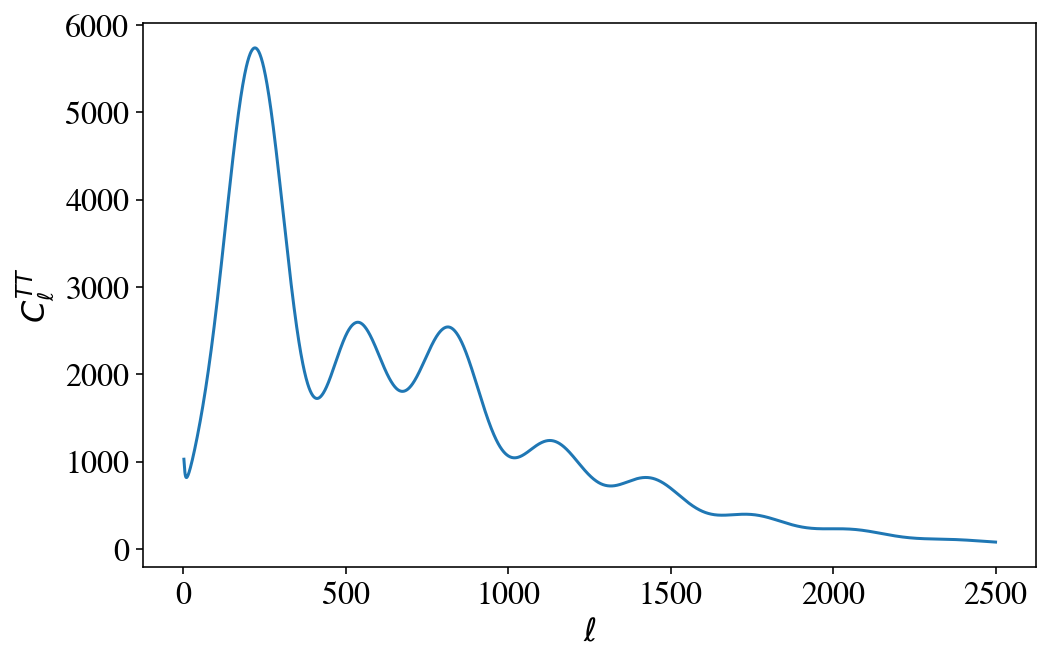

In [15]:
ll_max = 2500 #maximum \ell we will consider

Tcmb = M.T_cmb()*10**6 #cmb temp in micro kelvin, because
ll = np.arange(2, ll_max+1)
muK2 = (Tcmb)**2

######################################################
# Getting fiducial C_l's from CLASS. These were 
# computed in the previous cell. The factor of muK2
# is because CLASS C_l's are by default dimensionless
# and this puts them in more familiar units
######################################################

tt_fid = muK2*M.lensed_cl(ll_max)['tt'][2:] # 2:, because we want to ignore the monopole and dipole
te_fid = muK2*M.lensed_cl(ll_max)['te'][2:]
ee_fid = muK2*M.lensed_cl(ll_max)['ee'][2:]

######################################################
# The above array indices are shifted by 2 from the 
# corresponding l, i.e. tt_fid[0] = C^TT_(l=2). I 
# find this really annoying so I typically create
# dictionaries so that I can reference them by l value
# if I want, i.e. tt_dict[2] = C^TT_(l=2)
######################################################

fiducials = {}

tt_dict = {}
te_dict = {}
ee_dict = {}

for i,Cl in enumerate(tt_fid):
    tt_dict[i+2] = Cl
    te_dict[i+2] = te_fid[i]
    ee_dict[i+2] = ee_fid[i]
    fiducials.update({'tt': tt_dict, 'te': te_dict, 'ee': ee_dict})

fig,ax =plt.subplots(figsize=(8,5))
ax.plot(ll, ll*(ll+1)/(2*np.pi)*tt_fid)
ax.set_xlabel("$\ell$")
ax.set_ylabel("$C^{TT}_\ell$")
plt.show()

## Creating error covariance matrix

Now we want to implement Eq. (2) in code. We already have the fiducial $C_\ell$'s from the previous cell, so it is just a matter of collecting them into the appropriate form.

In [16]:
######################################################
# Being methodical, I create each row one at a time
# and then stack them for the final result
######################################################

row1 = np.stack([(tt_fid)**2, te_fid**2, (tt_fid)*te_fid], axis=1)
row2 = np.stack([te_fid**2, (ee_fid)**2, te_fid*(ee_fid)], axis=1)
row3 = np.stack([(tt_fid)*te_fid, te_fid*(ee_fid), 0.5*(te_fid**2 + (tt_fid)*(ee_fid))], axis=1)

sigma = np.stack([row1, row2, row3], axis=1)

fsky = 0.8
for i, ell in enumerate(ll):
    sigma[i]*=(2./((2*ell + 1)))/fsky

print(sigma.shape)
print(sigma[0,:,:])

(2499, 3, 3)
[[5.78926562e+05 3.88289421e+00 1.49930337e+03]
 [3.88289421e+00 5.70109096e-04 4.70496898e-02]
 [1.49930337e+03 4.70496898e-02 1.10251041e+01]]


We can see from the above that the resulting $\Sigma_l$ has the shape we want.

## Computing the CMB responses

Finally, we need to compute how the CMB (i.e. the $C^{XX}_\ell$) respond to slightly changing each parameter. That is, we are at the step where we want to compute $\partial C_\ell / \partial \theta_i$ for each parameter in $\vec{\theta}$. This will require calculating $C^{XX}_\ell$ on a grid of values. The general process is as follows.

Let $\alpha \in \vec{\theta}_{fid}$ be the parameter of interest. We start by choosing a small step size (say, 5% of the fiducial value) and generate a grid of trial values around the fiducial value. In the end we have an array that looks like:

$$
\left[\alpha_{-2}, \alpha_{-1}, \alpha_0, \alpha_{1}, \alpha_{2} \right]
$$

where $\alpha_{-2} = \alpha - 2 \Delta \alpha$, $\alpha_{-1} = \alpha - 1 \Delta \alpha$, and so on. For each of the values in this grid, we calculate $C^{XX}_\ell$ while keeping all other parameters fixed and save the result in an array. Take $C^{TT}_\ell$ for example, although the process is the same for the others. We have just calculated this 5 times, changing the value of $\alpha$ each time. So we have an array that looks like:

\begin{equation} \tag{4}
\begin{bmatrix}
C^{TT}_{2}|_{\alpha_{-2}} & C^{TT}_{2}|_{\alpha_{-1}} & C^{TT}_{2}|_{\alpha_{0}} & C^{TT}_{2}|_{\alpha_{1}} & C^{TT}_{2}|_{\alpha_{2}} \\
C^{TT}_{3}|_{\alpha_{-2}} & C^{TT}_{3}|_{\alpha_{-1}} & C^{TT}_{3}|_{\alpha_{0}} & C^{TT}_{3}|_{\alpha_{1}} & C^{TT}_{3}|_{\alpha_{2}} \\
                  &                   &   \vdots         &                  &                  \\
C^{TT}_{2500}|_{\alpha_{-2}} & C^{TT}_{2500}|_{\alpha_{-1}} & C^{TT}_{2500}|_{\alpha_{-0}} & C^{TT}_{2500}|_{\alpha_{1}} & C^{TT}_{2500}|_{\alpha_{2}}
\end{bmatrix}
\end{equation}

Each row of this array is  $C^{TT}_\ell$ at a specific $\ell$ value for 5 closely separated values of the parameter $\alpha$. To compute the derivative, we just need to calculate finite differences across the columns, and to evaluate the result at the fiducial value we just need to save the result at the middle index of the resulting array. We then repeat this for the other $C^{XX}_\ell$. This is easier to see in code, I think.

In [17]:
######################################################
# This function implements the above process. If you
# are not using CLASS, some parts of it will have to 
# change, but the logic in general will remain the 
# same.
######################################################

def compute_cmb_response(parameter_name, parameter_value, percent=0.05):
    """ Computes the CMB response to varying a standard parameter.
        Parameters are incremented by a fixed percentage supplied
        by the percent argument.
    """
    dp = percent*parameter_value
    trial_values = np.linspace(-2*dp, 2*dp, 5) + parameter_value #creates a grid of values centered on the fiducial one
    middle=2 #index of center of array of length 5

    tt_array=[] # this will become the large array referenced above
    te_array=[]
    ee_array=[]

    for trial in trial_values:
        M = Class.Class()
        M.set(common_settings) #set up CLASS with all the fiducial values
        M.set({parameter_name: trial}) #change the one value we are currently varying
        M.compute()
        cls = M.lensed_cl(ll_max)
        tt_array.append(cls['tt'][2:])
        te_array.append(cls['te'][2:])
        ee_array.append(cls['ee'][2:])
        
    tt_array = np.vstack(tt_array)
    te_array = np.vstack(te_array)
    ee_array = np.vstack(ee_array)
    tt_grad = np.gradient(tt_array, dp, axis=0)[middle] #np.gradient computes the derivate for us, dp specifes the spacing between points in tt_array
    te_grad = np.gradient(te_array, dp, axis=0)[middle]
    ee_grad = np.gradient(ee_array, dp, axis=0)[middle]

    return [tt_grad, te_grad, ee_grad]

######################################################
# We need to call the above function 6 times, one for
# each of the parameters we are varying.
######################################################

tt_derivs = []
te_derivs = []
ee_derivs = []

for param_name, fiducial_value in standard_params.items():
    print("Varying parameter: {}".format(param_name))
    cmb_responses = compute_cmb_response(param_name, fiducial_value)
    tt_derivs.append(cmb_responses[0])
    te_derivs.append(cmb_responses[1])
    ee_derivs.append(cmb_responses[2])

# tt_derivs[0] now holds the array (of length ll_max) containing the derivative of our first parameter, and so on

dCl = muK2*np.stack([tt_derivs, ee_derivs, te_derivs], axis=1)

print(dCl.shape)

Varying parameter: omega_b
Varying parameter: omega_cdm
Varying parameter: n_s
Varying parameter: tau_reio
Varying parameter: ln10^{10}A_s
Varying parameter: H0
(6, 3, 2499)


Finally, all we need to do is implement Eq. (1) in code. The first thing that we will do is invert $\Sigma_\ell$, and next we will do Eq. (1) all in one swoop. We will use the `numpy` function `np.einsum`. This can be a bit convoluted at first, but it is an extremely efficient way to do matrix multiplication in python. Without it, we would have to do $2\times \ell_{max}$ matrix multiplications of a $6 \times 6$ matrix by a $3 \times 1$ vector, plus a matrix inversion for each $\ell$. This function does that, but does it very quickly.

In [18]:
sigma_inv = np.linalg.inv(sigma)
Fisher = np.einsum("iXl,lXY,jYl->ij", dCl, sigma_inv, dCl)

print(Fisher.shape)
print(Fisher)

(6, 6)
[[ 4.97534134e+09 -9.92410246e+08  1.06756497e+08 -1.68268180e+08
   8.71318256e+07 -2.78274621e+06]
 [-9.92410246e+08  4.03337117e+08 -1.71056367e+07  3.72270571e+07
  -1.90867903e+07  1.03691372e+06]
 [ 1.06756497e+08 -1.71056367e+07  4.81544388e+06 -8.71127591e+06
   4.47179579e+06 -4.58464337e+04]
 [-1.68268180e+08  3.72270571e+07 -8.71127591e+06  2.03023249e+07
  -1.02773414e+07  8.38069228e+04]
 [ 8.71318256e+07 -1.90867903e+07  4.47179579e+06 -1.02773414e+07
   5.30924230e+06 -4.38971256e+04]
 [-2.78274621e+06  1.03691372e+06 -4.58464337e+04  8.38069228e+04
  -4.38971256e+04  2.76416205e+03]]


## Pretty printing

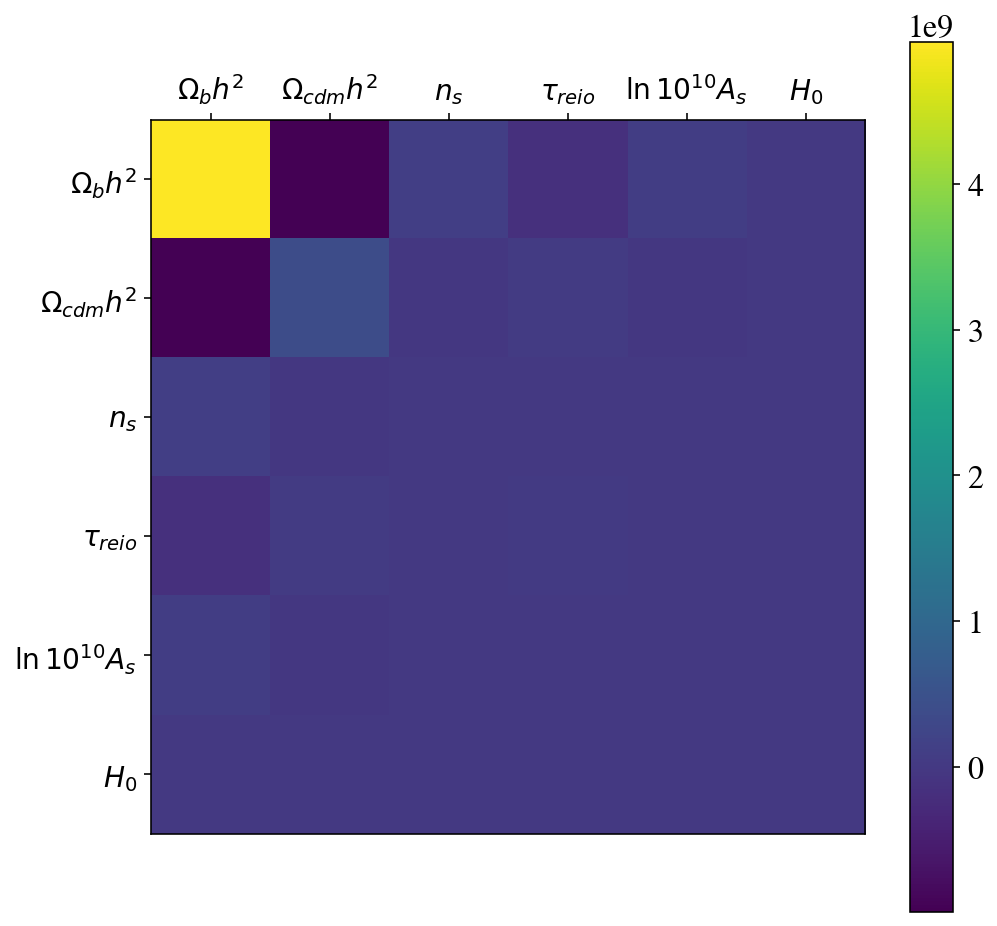

In [19]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
from matplotlib import cm

tick_label_list = ['$\Omega_b h^2$', '$\Omega_{cdm}h^2$', '$n_s$', '$\\tau_{reio}$', '$\ln10^{10}A_s$', '$H_0$']

fig,ax = plt.subplots(figsize=(8,8))

m = ax.imshow(Fisher, cmap=cm.viridis)

ax.set_xticks(np.arange(6))
ax.set_yticks(np.arange(6))

ax.set_xticklabels(tick_label_list, fontsize=14)
ax.set_yticklabels(tick_label_list, fontsize=14)

ax.xaxis.tick_top()

plt.colorbar(m)
plt.show()